In [1]:
!pip install medmnist

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 110.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 86.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 41.6 MB/s eta 0:00:00
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114249 sha256=

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.utils as vutils
from medmnist import ChestMNIST
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
import os

In [3]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
print(device)

cuda


In [5]:
# Load MedMNIST Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [6]:
from medmnist import ChestMNIST

# Load MedMNIST Dataset without downloading
train_dataset = ChestMNIST(split="train", transform=transform, download=True) # Set download=True to download the dataset
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

100%|██████████| 82.8M/82.8M [00:07<00:00, 11.1MB/s]


In [7]:
# Generator Model
class Generator(nn.Module):
    def __init__(self, z_dim=100):
        super(Generator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(z_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 28*28),
            nn.Tanh()
        )

    def forward(self, z):
        return self.net(z).view(-1, 1, 28, 28)

# Discriminator Model
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1)
        )

    def forward(self, x):
        return self.net(x.view(x.size(0), -1))

In [8]:
# WGAN-GP Gradient Penalty
def gradient_penalty(D, real_data, fake_data):
    alpha = torch.rand(real_data.size(0), 1, 1, 1).to(device)
    interpolates = (alpha * real_data + (1 - alpha) * fake_data).requires_grad_(True)
    d_interpolates = D(interpolates)
    grad_outputs = torch.ones_like(d_interpolates)
    gradients = torch.autograd.grad(
        outputs=d_interpolates, inputs=interpolates, grad_outputs=grad_outputs,
        create_graph=True, retain_graph=True)[0]
    return ((gradients.norm(2, dim=1) - 1) ** 2).mean()

In [9]:
# Training Function
def train_gan(gan_type, num_epochs=50):
    writer = SummaryWriter(f"runs/{gan_type}")

    z_dim = 100
    generator = Generator(z_dim).to(device)
    discriminator = Discriminator().to(device)

    optim_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
    optim_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

    for epoch in range(num_epochs):
        for real, _ in tqdm(train_loader):
            real = real.to(device)

            # Generate fake images
            z = torch.randn(real.size(0), z_dim).to(device)
            fake = generator(z)

            # Discriminator update
            optim_D.zero_grad()
            real_loss, fake_loss = 0, 0

            if gan_type == "LS-GAN":
                real_loss = 0.5 * ((discriminator(real) - 1) ** 2).mean()
                fake_loss = 0.5 * (discriminator(fake) ** 2).mean()
            elif gan_type == "WGAN":
                real_loss = -discriminator(real).mean()
                fake_loss = discriminator(fake).mean()
            elif gan_type == "WGAN-GP":
                real_loss = -discriminator(real).mean()
                fake_loss = discriminator(fake).mean()
                gp = gradient_penalty(discriminator, real, fake)
                loss_D = real_loss + fake_loss + 10 * gp
            else:
                raise ValueError("Invalid GAN type")

            loss_D = real_loss + fake_loss
            loss_D.backward()
            optim_D.step()

            # Generator update
            if epoch % 5 == 0:
                optim_G.zero_grad()
                fake = generator(z)
                loss_G = -discriminator(fake).mean() if gan_type in ["WGAN", "WGAN-GP"] else ((discriminator(fake) - 1) ** 2).mean()
                loss_G.backward()
                optim_G.step()

                # TensorBoard Logging
                writer.add_scalar("Loss/Discriminator", loss_D.item(), epoch)
                writer.add_scalar("Loss/Generator", loss_G.item(), epoch)

        # Save generated images
        vutils.save_image(fake[:25], f"generated/{gan_type}_epoch_{epoch}.png", normalize=True)

    torch.save(generator.state_dict(), f"models/{gan_type}_generator.pth")
    writer.close()


In [10]:
# Ensure directories exist
os.makedirs("generated", exist_ok=True)
os.makedirs("models", exist_ok=True)

In [11]:
# Train all three GANs
for gan in ["LS-GAN", "WGAN", "WGAN-GP"]:
    train_gan(gan)

100%|██████████| 1227/1227 [00:19<00:00, 62.89it/s]


# **Evaluation**

# ******Check with self-written code

In [4]:
import os
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.models as models
import numpy as np
from scipy.linalg import sqrtm
from medmnist import ChestMNIST
import torch.nn as nn

# Set device
device = torch.device("cpu")

# Load Pretrained InceptionV3 Model
inception_model = models.inception_v3(weights=models.Inception_V3_Weights.DEFAULT).to(device)
inception_model.fc = torch.nn.Identity()  # Remove last layer
inception_model.eval()

# Transform pipeline for real images
transform = transforms.Compose([
    transforms.Resize((299, 299)),  # Resize for InceptionV3
    transforms.Grayscale(num_output_channels=3),  # Convert to 3-channel RGB
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize for Inception
])

# Load Real Images
real_dataset = ChestMNIST(split="test", transform=transform, download=True)
real_loader = torch.utils.data.DataLoader(real_dataset, batch_size=64, shuffle=False)

# Define Generator Model
class Generator(nn.Module):
    def __init__(self, latent_dim=100, img_channels=1):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 28 * 28),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(z.size(0), 1, 28, 28)  # Reshape to image
        return img

# Function to Extract Features
def get_features(images, model):
    """Extract features from images using InceptionV3"""
    with torch.no_grad():
        images = images.to(device).float()  # Ensure float32 dtype
        images = F.interpolate(images, size=(299, 299), mode="bilinear", align_corners=False)  # Resize
        images = images.repeat(1, 3, 1, 1)  # Convert grayscale to RGB
        features = model(images)
    return features.cpu().numpy()

# Compute Inception Score
def compute_inception_score(images):
    """Calculate Inception Score using KL divergence"""
    features = get_features(images, inception_model)
    probs = F.softmax(torch.tensor(features), dim=1).numpy()

    # Compute KL Divergence
    p_mean = np.mean(probs, axis=0, keepdims=True)
    kl_div = probs * (np.log(probs) - np.log(p_mean))
    kl_sum = np.sum(kl_div, axis=1)

    # Compute IS
    inception_score = np.exp(np.mean(kl_sum))
    return inception_score

# Compute Frechet Inception Distance (FID)
def compute_fid(real_images, fake_images):
    """Calculate Frechet Inception Distance (FID)"""
    real_features = get_features(real_images, inception_model)
    fake_features = get_features(fake_images, inception_model)

    # Compute Mean and Covariance
    mu_real, sigma_real = np.mean(real_features, axis=0), np.cov(real_features, rowvar=False)
    mu_fake, sigma_fake = np.mean(fake_features, axis=0), np.cov(fake_features, rowvar=False)

    # Compute FID Score
    mean_diff = np.sum((mu_real - mu_fake) ** 2)
    sqrt_product = sqrtm(sigma_real.dot(sigma_fake))

    if np.iscomplexobj(sqrt_product):
        sqrt_product = sqrt_product.real  # Discard imaginary part if needed

    fid = mean_diff + np.trace(sigma_real + sigma_fake - 2 * sqrt_product)
    return fid

# Function to Load Model with Key Mapping Fix
def load_generator(model_path):
    generator = Generator().to(device)
    try:
        state_dict = torch.load(model_path, map_location=device)

        # Rename keys if they are stored under "net."
        new_state_dict = {key.replace("net.", "model."): value for key, value in state_dict.items()}

        generator.load_state_dict(new_state_dict, strict=False)
        generator.eval()
        return generator
    except Exception as e:
        print(f"Error loading {model_path}: {e}")
        return None

# Main Function to Compute Metrics
def compute_metrics():
    real_images = next(iter(real_loader))[0].to(device)

    # Normalize real images to [0,1] range
    real_images = (real_images + 1) / 2
    real_images = (real_images * 255).float()  # Convert to float32

    model_paths = [
        "/content/models/LS-GAN_generator.pth",
        "/content/models/WGAN_generator.pth",
        "/content/models/WGAN-GP_generator.pth"
    ]

    for model_path in model_paths:
        if not os.path.exists(model_path):
            print(f"Error: Model file {model_path} not found!")
            continue

        generator = load_generator(model_path)
        if generator is None:
            continue  # Skip this model if loading failed

        # Generate Fake Images
        fake_images = torch.cat([generator(torch.randn(64, 100).to(device)) for _ in range(10)], dim=0)
        fake_images = (fake_images + 1) / 2
        fake_images = (fake_images * 255).float()  # Convert to float32

        # Resize Fake Images for Inception
        fake_images = F.interpolate(fake_images, size=(299, 299), mode="bilinear", align_corners=False)

        # Compute IS and FID
        inception_score = compute_inception_score(fake_images)
        fid_value = compute_fid(real_images, fake_images)

        print(f"{model_path.split('/')[-1]} - Inception Score: {inception_score:.4f}, FID: {fid_value:.4f}")

compute_metrics()


LS-GAN_generator.pth - Inception Score: 1.0180, FID: 381.1291
WGAN_generator.pth - Inception Score: 1.0000, FID: 14209.2605
WGAN-GP_generator.pth - Inception Score: 1.0000, FID: 25866.8185


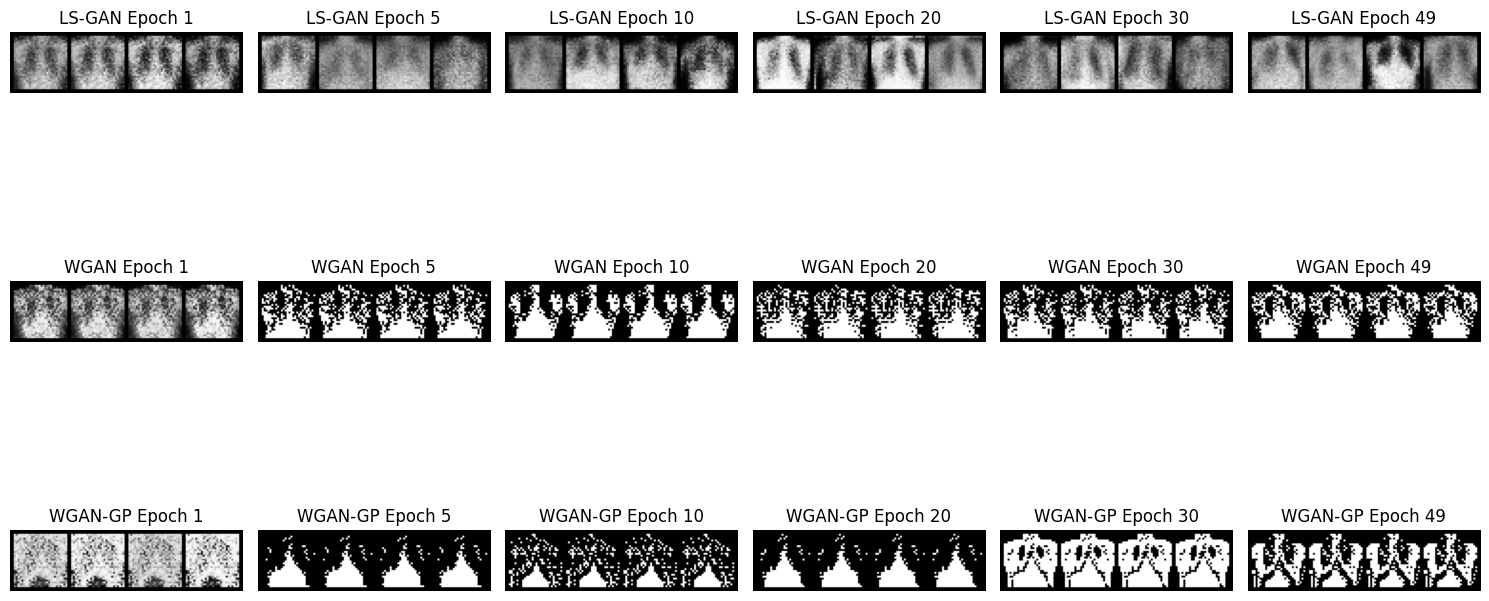

In [5]:
import os
import matplotlib.pyplot as plt
from PIL import Image

# Define GAN types and epochs to display
gan_types = ["LS-GAN", "WGAN", "WGAN-GP"]
epochs_to_show = [1, 5, 10, 20, 30, 49]

# Folder where images are stored
generated_folder = "/content/generated"

# Create subplots
fig, axes = plt.subplots(len(gan_types), len(epochs_to_show), figsize=(15, 9))

for i, gan_type in enumerate(gan_types):
    for j, epoch in enumerate(epochs_to_show):
        img_path = os.path.join(generated_folder, f"{gan_type}_epoch_{epoch}.png")

        if os.path.exists(img_path):
            img = Image.open(img_path)
            axes[i, j].imshow(img)
            axes[i, j].axis("off")
            axes[i, j].set_title(f"{gan_type} Epoch {epoch}")
        else:
            axes[i, j].set_visible(False)  # Hide missing images

plt.tight_layout()
plt.show()


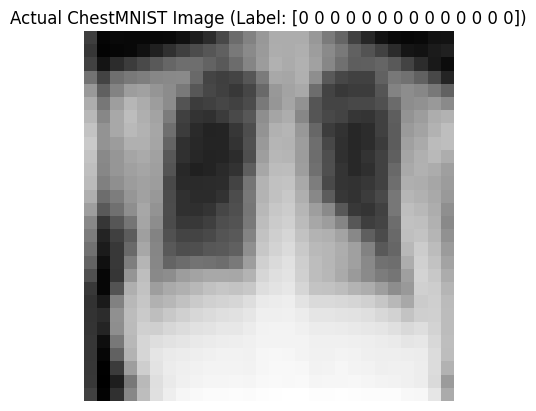

In [6]:
import matplotlib.pyplot as plt
import torch
from medmnist import ChestMNIST

# Load MedMNIST Dataset
train_dataset = ChestMNIST(split="train", transform=None, download=True)

# Extract one image and label
image, label = train_dataset[0]  # Get the first image

# Convert to numpy for plotting
if isinstance(image, torch.Tensor):
    image = image.numpy().squeeze()  # Convert tensor to numpy and remove extra dimensions

# Plot the actual image
plt.imshow(image, cmap="gray")
plt.axis("off")
plt.title(f"Actual ChestMNIST Image (Label: {label})")
plt.show()
